# 1.Sử dụng các checkpoint đã huấn luyện để đoán nhận dữ liệu

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

In [1]:
#@title Nhập tên các bộ dữ liệu đoán nhận
# là bộ dữ liệu hiện tại, được tạo trong lần đoán nhận này (tên file là lần đoán nhận này)
# sẽ trộn cả 2 bộ để đem ra đoán, nếu muốn đoán nhận từng bộ riêng lẻ thì comment lại bộ khác
# dùng model hiện tại để doán nhận bộ dữ liệu hiện tại => 2 bộ dưới là 2 bộ dữ liệu hiện tại
L_source = ",".join(map(lambda x: f"/cic/dataset/normalized_labeled/{x}/", [
    'nsm-2023w09-04-label',
    #'nsm-2023w09-02-label',
    #'nsm-2023w09-01-label',
    #'nsm-2023w08-dos-01-label',
]))

In [17]:
#@title Nhập tên các checkpoint
# dòng đầu tiên, 2023W0702, là checkpoint hiện tại
# dòng thứ 2 trở đi, 2023W0701 ...., là các checkpoint quá khứ để đoán dữ liệu hiện tại là 2023W0702
# mỗi dòng, checkpoint là một model version được tải lên để đoán nhận các bộ dữ liệu L_source ở bên trên.
checkpoints = [
    #'2023W0904',
    '2023W0902',
    '2023W0901',
    #'2023W0801',
    #'2023W0704',
    #'2023W0703',
    #'2023W0702',
    #'2023W0701',
    #'2023W0604',
]

# 2.PREPARATION

In [3]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-03-12 12:58:01.020938: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-12 12:58:03.236764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 292 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-12 12:58:03.237893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13129 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-12 12:58:03.239353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13129 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability:

In [4]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pandas as pd
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from tensorflow import keras

import common
from anomaly_normalization import LABEL
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, IMG, read_csv_in_dir

run, client = common.init_experiment(name='notebook')


2023-03-12 12:58:06,250[INFO][140086694836032-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 192.168.2.236:6379
[2023-03-12 12:58:06,366 I 21556 21556] global_state_accessor.cc:357: This node has an IP address of 172.18.12.180, while we can not found the matched Raylet address. This maybe come from when you connect the Ray cluster with a different IP address or connect a container.
2023-03-12 12:58:07,211[INFO][140086694836032-MainThread] migration.py:__init__(204) Context impl PostgresqlImpl.
2023-03-12 12:58:07,212[INFO][140086694836032-MainThread] migration.py:__init__(211) Will assume transactional DDL.


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [5]:
#@title Generate an input sequence
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 79   #@param {type:"integer"}

L_data: Dataset = read_csv_in_dir(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))

total_size = int(L_count.sum()['count()']) // n_timesteps_in
predict_size = total_size
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('predict_size = ', predict_size)


L_predict = DataFrame.from_records(L_data.take(predict_size  * n_timesteps_in))
L_predict[Lpadding_features] = 0
LX_predict = L_predict[features].to_numpy().reshape(predict_size, n_timesteps_in, n_features)
Ly_predict = L_predict[[LABEL]].to_numpy().reshape((predict_size, n_timesteps_in))

Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 90.01it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [6]:
L_count

,label,count()
0,0.0,45484
1,1.0,104709


## Data preview

### L_train preview

In [7]:
L_predict[[LABEL, *features]]

,label,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
0,0.0,0.995055,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.988569,0.0,0.0,0.0,0.0,0.964028,1.0,0.0,0.761594,1.000000,1.0,1.0,1.0,1.0,1.0,0.999129,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.859049,0.761594,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.000000,0.0,1.000000,1.0,1.000000,0.999988,0.761594,0.000000,1.0,0.0,0.0,1.000000,0.000000,0.000000,0.964028,0.761594,0.0,1.0,0.0
1,0.0,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.000000,1.0,1.0,1.0,1.0,0.0,1.000000,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.000000,0.761594,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.000000,0.0,1.000000,1.0,1.000000,0.999988,0.761594,0.000000,1.0,0.0,0.0,1.000000,0.761594,0.000000,0.000000,0.964028,0.0,1.0,0.0
2,0.0,1.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.999909,1.000000,0.0,1.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.995055,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.000000,0.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.000000,0.0,1.000000,1.0,1.000000,0.999988,0.999909,0.000000,1.0,1.0,0.0,1.000000,0.000000,0.964028,0.999329,0.999988,1.0,1.0,0.0
3,0.0,1.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.000000,0.918468,0.0,1.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.000000,1.0,1.0,1.0,1.0,1.0,0.997569,0.999329,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.944322,0.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.000000,0.0,1.000000,1.0,1.000000,0.999988,1.000000,0.000000,1.0,1.0,0.0,1.000000,0.000000,0.964028,1.000000,1.000000,1.0,1.0,0.0
4,0.0,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.000000,1.0,1.0,1.0,1.0,0.0,1.000000,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.000000,0.761594,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.000000,0.0,1.000000,1.0,1.000000,0.999988,0.761594,0.000000,1.0,0.0,0.0,1.000000,0.761594,0.000000,0.000000,0.964028,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150095,0.0,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.000000,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.999988,0.000000,0.761594,1.0,0.0,0.0,0.000000,0.761594,0.000000,0.000000,0.964028,0.0,0.0,0.0
150096,1.0,0.995055,1.0

In [8]:
L_predict[[LABEL, *features]].describe()

,label,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
count,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.0,150100.000000,150100.0,150100.000000,150100.000000,150100.0,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.0,150100.0,1.501000e+05,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.0,150100.000000,150100.000000,150100.000000,1.501000e+05,150100.0,150100.0,150100.0,150100.0,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,1.501000e+05,150100.000000,150100.000000,150100.0,150100.000000,150100.0,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.000000,150100.0
mean,0.697209,0.978682,0.405623,0.405623,0.405623,0.311532,0.275030,0.275030,0.781099,0.752538,0.752538,0.751617,0.533271,0.752538,0.226266,0.226265,0.036948,0.211726,0.275011,0.387219,0.0,0.226265,0.0,0.000107,0.301922,1.0,0.000107,0.177516,0.798181,0.999665,0.999825,0.999665,0.967453,0.806158,0.665256,0.572553,0.0,0.0,1.000000e+00,0.768186,0.768093,0.740404,0.582601,0.768093,0.809253,0.808873,0.263565,0.554689,0.0,0.558174,0.265584,0.808873,1.000000e+00,0.0,1.0,1.0,1.0,0.407748,0.512692,0.977808,0.817788,0.817032,0.007135,0.812764,0.812275,0.817245,9.999877e-01,0.753685,0.355498,1.0,0.225862,0.0,0.805620,0.166714,0.458429,0.766293,0.937929,0.226357,0.809744,0.0
std,0.459467,0.102088,0.491014,0.491014,0.491014,0.463116,0.446531,0.446531,0.413503,0.431539,0.431539,0.432061,0.498893,0.431539,0.418309,0.418307,0.188391,0.402103,0.446499,0.402314,0.0,0.418307,0.0,0.009008,0.424199,0.0,0.009008,0.326825,0.382623,0.025807,0.018609,0.025807,0.250706,0.395292,0.356119,0.488979,0.0,0.0,7.636634e-09,0.421990,0.422160,0.468485,0.493124,0.422160,0.392295,0.392418,0.440159,0.493030,0.0,0.416456,0.362951,0.392418,1.167536e-08,0.0,0.0,0.0,0.0,0.491418,0.499841,0.147308,0.385434,0.385699,0.084160,0.389259,0.389854,0.385619,6.374490e-07,0.374368,0.386340,0.0,0.418111,0.0,0.394172,0.314921,0.481701,0.407665,0.097794,0.418447,0.392382,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.0,0.0,9.999998e-01,0.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,9.999998e-01,0.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.

In [9]:
DataFrame.from_records(LX_predict[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
0,0.995055,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.988569,0.0,0.0,0.0,0.0,0.964028,1.0,0.0,0.761594,1.0,1.000000,1.000000,1.000000,1.000000,1.0,0.999129,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,1.0,1.0,1.0,0.0,0.0,0.859049,0.761594,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,0.761594,0.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.964028,0.761594,0.0,1.0,0.0
1,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,0.0,0.0,1.0,1.000000,1.000000,1.000000,0.0,1.000000,1.0,1.0,0.0,1.0,0.0,1.000000,0.761594,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,0.761594,0.0,1.0,0.0,0.0,1.0,0.761594,0.000000,0.000000,0.964028,0.0,1.0,0.0
2,1.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.999909,1.000000,0.0,1.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.995055,0.0,0.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,0.0,1.0,0.0,1.000000,0.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,0.999909,0.0,1.0,1.0,0.0,1.0,0.000000,0.964028,0.999329,0.999988,1.0,1.0,0.0
3,1.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.000000,0.918468,0.0,1.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.000000,1.000000,1.000000,1.000000,1.0,0.997569,0.999329,0.0,0.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,0.0,1.0,0.0,0.944322,0.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,1.000000,0.0,1.0,1.0,0.0,1.0,0.000000,0.964028,1.000000,1.000000,1.0,1.0,0.0
4,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,0.0,0.0,1.0,1.000000,1.000000,1.000000,0.0,1.000000,1.0,1.0,0.0,1.0,0.0,1.000000,0.761594,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,0.761594,0.0,1.0,0.0,0.0,1.0,0.761594,0.000000,0.000000,0.964028,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,0.0,0.0,1.0,1.000000,1.000000,1.000000,0.0,1.000000,1.0,1.0,0.0,1.0,0.0,1.000000,0.761594,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,0.761594,0.0,1.0,0.0,0.0,1.0,0.761594,0.000000,0.000000,0.964028,0.0,1.0,0.0
96,0.964028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,0.999998,0.999998,0.999998,0.999998,0.0,1.000000,0.000000,0.0,0.0,1.0,0.999998,0.999998,0.999998,0.0,0.999998,1.0,1.0,0.0,1.0,0.0,1.000000,0.761594,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,0.761594,0.0,1.0,0.0,0.0,1.0,0.761594,0.000000,0.000000,0.964028,0.0,1.0,0.0
97,1.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.999909,1.000000,0.0,1.0,0.0,0.0,0.000000,1.0,0.0,0.761594,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.995055,0.0,0.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,0.0,1.0,0.0,1.000000,0.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.999988,0.999909,0.0,1.0,1.0,0.0,1.0,0.000000,0.964028,0.999329,0.9999

In [10]:
DataFrame.from_records(LX_predict[0]).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.0,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.0,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,0.990852,0.180000,0.180000,0.180000,0.070000,0.650000,0.650000,0.750000,0.730000,0.730000,0.729951,0.710000,0.730000,0.700000,0.700000,0.050000,0.650000,0.649959,0.656287,0.0,0.700000,0.0,0.0,0.166318,1.0,0.0,0.719947,0.969123,1.000000,1.000000,1.000000,0.999567,0.750000,0.936871,0.723848,0.0,0.0,1.0,0.970000,0.970000,0.969609,0.730000,0.970000,0.977616,0.977616,0.027616,0.960000,0.0,0.910416,0.243710,0.977616,1.0,0.0,1.0,1.0,1.0,0.180000,0.740000,1.0,0.977616,0.975164,0.0,0.974888,0.972782,0.975828,0.999988,0.909855,0.017566,1.0,0.700000,0.0,0.970000,0.190399,0.626618,0.744228,0.984104,0.700000,0.979951,0.0
std,0.015588,0.386123,0.386123,0.386123,0.256432,0.479372,0.479372,0.435194,0.446196,0.446196,0.446166,0.456048,0.446196,0.460566,0.460566,0.219043,0.479372,0.479342,0.450436,0.0,0.460566,0.0,0.0,0.326028,0.0,0.0,0.185011,0.169472,0.000001,0.000001,0.000001,0.003625,0.435194,0.218509,0.443097,0.0,0.0,0.0,0.171447,0.171447,0.171415,0.446196,0.171447,0.142373,0.142373,0.159030,0.196946,0.0,0.234448,0.357055,0.142373,0.0,0.0,0.0,0.0,0.0,0.386123,0.440844,0.0,0.142373,0.148126,0.0,0.149011,0.157215,0.146185,0.000000,0.190949,0.124694,0.0,0.460566,0.0,0.171447,0.331441,0.462128,0.433151,0.042206,0.460566,0.140699,0.0
min,0.964028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.999988,0.999988,0.999988,0.964028,0.000000,0.066473,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.033273,0.000000,0.000000,1.0,0.0,1.0,1.0,1.0,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.999988,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.761594,0.000000,0.000000,0.0
25%,0.987298,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024955,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.761594,1.000000,1.000000,1.000000,1.000000,1.000000,0.750000,0.999256,0.000000,0.0,0.0,1.0,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.0,0.964918,0.000000,1.000000,1.0,0.0,1.0,1.0,1.0,0.000000,0.000000,1.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.999988,0.761594,0.000000,1.0,0.000000,0.0,1.000000,0.000000,0.000000,0.571196,0.964028,0.000000,1.000000,0.0
50%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.999909,0.984144,0.0,1.000000,0.0,0.0,0.000000,1.0,0.0,0.761594,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.995055,0.0,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.0,1.000000,0.000000,1.000000,1.0,0.0,1.0,1.0,1.0,0.000000,1.000000,1.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.

In [11]:
DataFrame.from_records(Ly_predict)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
1497,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
1498,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
1499,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0

In [12]:
DataFrame.from_records(Ly_predict).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
count,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000
mean,0.704197,0.690207,0.688208,0.690873,0.701532,0.720187,0.710859,0.700200,0.702199,0.710193,0.686875,0.698201,0.700866,0.716855,0.717522,0.698201,0.686875,0.692871,0.694204,0.707528,0.668887,0.694870,0.702199,0.692871,0.708195,0.690207,0.698867,0.698867,0.703531,0.702199,0.688208,0.690873,0.713524,0.702865,0.699534,0.689540,0.687542,0.692871,0.700866,0.710859,0.696869,0.694870,0.724850,0.693538,0.699534,0.688208,0.696869,0.708195,0.719520,0.701532,0.680879,0.698867,0.702865,0.691539,0.699534,0.678881,0.692205,0.687542,0.702865,0.692871,0.697535,0.686875,0.686209,0.695536,0.685543,0.690207,0.692205,0.702865,0.694204,0.696869,0.702865,0.693538,0.692871,0.703531,0.706196,0.700866,0.694204,0.696869,0.698201,0.700200,0.702199,0.691539,0.702865,0.712858,0.704197,0.688874,0.698201,0.703531,0.700200,0.680879,0.676216,0.686875,0.712192,0.688208,0.680213,0.694204,0.690873,0.694870,0.698867,0.687542
std,0.456555,0.462562,0.463380,0.462288,0.457738,0.449057,0.453514,0.458323,0.457444,0.453824,0.463919,0.459191,0.458031,0.450676,0.450355,0.459191,0.463919,0.461457,0.460897,0.455049,0.470770,0.460616,0.457444,0.461457,0.454745,0.462562,0.458903,0.458903,0.456852,0.457444,0.463380,0.462288,0.452265,0.457149,0.458614,0.462836,0.463650,0.461457,0.458031,0.453514,0.459765,0.460616,0.446739,0.461178,0.458614,0.463380,0.459765,0.454745,0.449383,0.457738,0.466291,0.458903,0.457149,0.462012,0.458614,0.467062,0.461735,0.463650,0.457149,0.461457,0.459479,0.463919,0.464187,0.460333,0.464454,0.462562,0.461735,0.457149,0.460897,0.459765,0.457149,0.461178,0.461457,0.456852,0.455655,0.458031,0.460897,0.459765,0.459191,0.458323,0.457444,0.462012,0.457149,0.452579,0.456555,0.463108,0.459191,0.456852,0.458323,0.466291,0.468075,0.463919,0.452892,0.463380,0.466549,0.460897,0.462288,0.460616,0.458903,0.463650
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

## Data visualization

In [13]:
#@title create data IMG
IMG['LX_predict'], IMG['Ly_predict'] = ray.get([
    show_scattered_4d.remote(LX_predict, 'LX_predict'),
    show_scattered_4d.remote(Ly_predict, 'Ly_predict'),
])

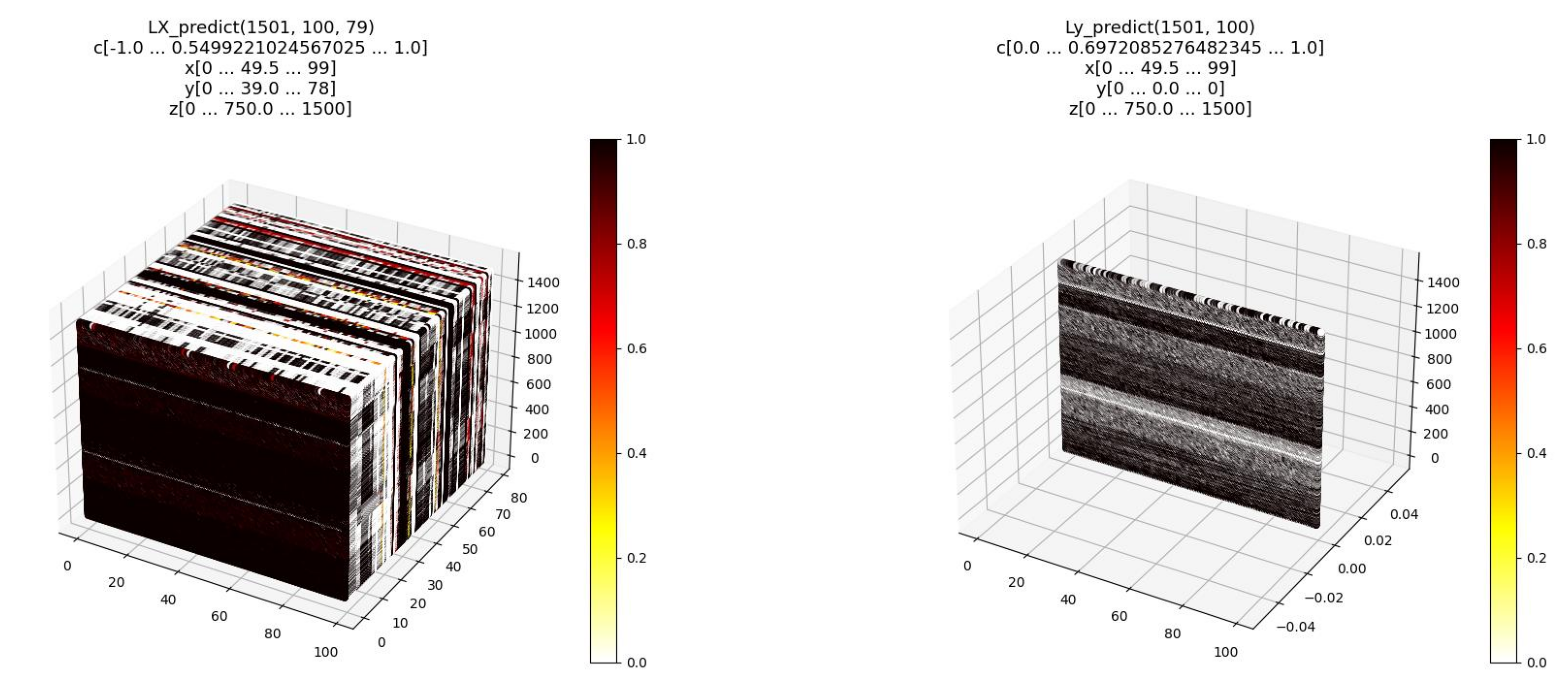

In [14]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_predict','Ly_predict'])

# 4.INTRODUCTION

# 5.LSTM Anomaly State management

## 5.1.Model layers



In [15]:
# threshold(num) là ngưỡng quyết định kết quả dữ đoán là anomaly hay benign, ví dụ: 0.5 ở đây là
# nếu kết quả dự đoán > 0.5 thì xem là anomaly, còn lại là benign, kết quả dự đoán của 1 flow
def threshold(num):
    return 1 if num > 0.5 else 0

def infer_by_checkpoint(checkpoint, name='model6'):
    model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
    Ly_predict_predicted=model.predict(LX_predict)
    predicted = np.vectorize(threshold)(Ly_predict_predicted)
    
    actual = predicted.ravel()
    expected = Ly_predict.ravel()
    anomaly_detected = anomaly_incorrect = benign_detected = benign_incorrect = 0
    for i in range(0, len(actual)):
        anomaly_detected += actual[i] == expected[i] == 1
        anomaly_incorrect += (actual[i] == 0) & (expected[i] == 1)
        benign_detected += actual[i] == expected[i] == 0
        benign_incorrect += (actual[i] == 1) & (expected[i] == 0)
    
    df = DataFrame.from_dict({
        'checkpoint': [checkpoint],
        'anomaly_detected': [anomaly_detected],
        'anomaly_incorrect': [anomaly_incorrect],
        'benign_detected': [benign_detected],
        'benign_incorrect': [benign_incorrect],
        'detected': [anomaly_detected + benign_detected],
        'incorrect': [anomaly_incorrect + benign_incorrect],
        'detected_rate': [(anomaly_detected + benign_detected) / len(actual)],
        'incorrect_rate': [(anomaly_incorrect + benign_incorrect) / len(actual)],
    })    
    print(df.to_string())

    [IMG['Ly_predict_predicted']] = ray.get([
        show_scattered_4d.remote(Ly_predict_predicted, "Ly_predict_predicted"),
    ])
    show_4d_imgs(['LX_predict','Ly_predict','Ly_predict_predicted'])
    
    return df

___

# 6.LSTM Anomaly model (Primary)

## 6.3.Infer



In [18]:
df = DataFrame()
for c in checkpoints:
    dfc = infer_by_checkpoint(c)
    df = pd.concat([df, dfc], axis=0, ignore_index=True)
df

2023-03-12 13:08:33.729207: E tensorflow/stream_executor/cuda/cuda_blas.cc:226] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2023-03-12 13:08:33.729256: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at matmul_op_impl.h:442 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


InternalError:  Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[node model/dense1/Tensordot/MatMul
 (defined at /usr/local/lib/python3.7/dist-packages/keras/layers/core/dense.py:202)
]] [Op:__inference_predict_function_13147]

Errors may have originated from an input operation.
Input Source operations connected to node model/dense1/Tensordot/MatMul:
In[0] model/dense1/Tensordot/Reshape:	
In[1] model/dense1/Tensordot/ReadVariableOp:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
>>>     "__main__", mod_spec)
>>> 
>>>   File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 17, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 992, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 712, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 215, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.7/asyncio/events.py", line 88, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py", line 387, in do_execute
>>>     cell_id=cell_id,
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
>>>     raw_cell, store_history, silent, shell_futures, cell_id
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
>>>     interactivity=interactivity, compiler=compiler, result=result)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_21556/4097480087.py", line 3, in <module>
>>>     dfc = infer_by_checkpoint(c)
>>> 
>>>   File "/tmp/ipykernel_21556/2590368924.py", line 8, in infer_by_checkpoint
>>>     Ly_predict_predicted=model.predict(LX_predict)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1789, in predict
>>>     tmp_batch_outputs = self.predict_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1621, in predict_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1611, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1604, in run_step
>>>     outputs = model.predict_step(data)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1572, in predict_step
>>>     return self(x, training=False)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py", line 452, in call
>>>     inputs, training=training, mask=mask)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/layers/core/dense.py", line 202, in call
>>>     outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
>>> 